In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from ds_creation.ds_utility import get_file_count
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from ds_creation.plot_utility import confusion_matrix_plot, metrics_plot_builder, get_metrics



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TRAIN_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")

h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)


2025-11-02 23:32:16.041376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 23:32:16.113437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 23:32:17.376959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# prendo il csv con gli mfcc e aggiungo una colonna con il nome del file
mfcc_df = pd.read_pickle('audio_data.pkl')
mfcc_df['file_name'] = mfcc_df['audio_files'].apply(lambda x: os.path.basename(x))
mfcc_df = mfcc_df.drop(columns=['idx_gruppo'])
mfcc_df['species'] = mfcc_df['species'].apply(lambda x: x.replace(',', ''))

# specie presenti nei dataset di train e test
species = get_file_count(TRAIN_DIR)
species = species[species['file_count']<1000]['species'].tolist()

# creo un dataframe con i nomi dei file di ogni specie con cui fare training
train_files_dict = {species:os.listdir(os.path.join(TRAIN_DIR, species)) for species in species}
train_files_df = pd.DataFrame([(species, file) for species, files in train_files_dict.items() for file in files], columns=['species', 'file_name'])

# creo un dataframe con i nomi dei file di ogni specie con cui fare testing
test_files_dict = {species:os.listdir(os.path.join(TEST_DIR, species)) for species in species}
test_files_df = pd.DataFrame([(species, file) for species, files in test_files_dict.items() for file in files], columns=['species', 'file_name'])

# creo i dataframe finali di train e test unendo i due dataframe precedenti con il dataframe degli mfcc
train_df = pd.merge(train_files_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)
test_df = pd.merge(test_files_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)




In [3]:
y_train = train_df['species']
y_test = test_df['species']
y_mapping = {label:idx for idx, label in enumerate(y_train.unique())}
y_train = y_train.map(y_mapping)
y_test = y_test.map(y_mapping)
print(type(train_df['chunk_list'][0]))
x_train = pd.DataFrame(train_df['chunk_list'].tolist())
x_train.columns = [f'mfcc_feature_{i}' for i in range(x_train.shape[1])]

x_test = pd.DataFrame(test_df['chunk_list'].tolist())
x_test.columns = [f'mfcc_feature_{i}' for i in range(x_test.shape[1])]


<class 'numpy.ndarray'>


In [4]:
x_train['label'] = y_train
x_test['label'] = y_test

x_train.to_csv('rf_train_data.csv', index=False)
x_test.to_csv('rf_test_data.csv', index=False)

In [5]:
pipeline_steps = [
    ('rf_classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
]

mfcc_pipeline = Pipeline(pipeline_steps)
mfcc_pipeline.fit(x_train, y_train)

y_pred = mfcc_pipeline.predict(x_test)

print("--- Risultati di Classificazione ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Report:")
print(classification_report(y_test, y_pred))

--- Risultati di Classificazione ---
Accuracy: 0.9934
Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      1.00      1.00       172
           2       1.00      1.00      1.00       137
           3       0.99      1.00      1.00       122
           4       1.00      1.00      1.00        93
           5       1.00      0.99      0.99        80
           6       1.00      1.00      1.00        77
           7       0.98      1.00      0.99        65
           8       1.00      0.98      0.99        61
           9       1.00      1.00      1.00        61
          10       0.97      1.00      0.99        37
          11       1.00      1.00      1.00        35
          12       1.00      1.00      1.00        34
          13       1.00      1.00      1.00        33
          14       1.00      1.00      1.00        33
          15       1.00      1.00      1.00        32
          16       

/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

I0000 00:00:1762126339.596093 2353005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16906 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


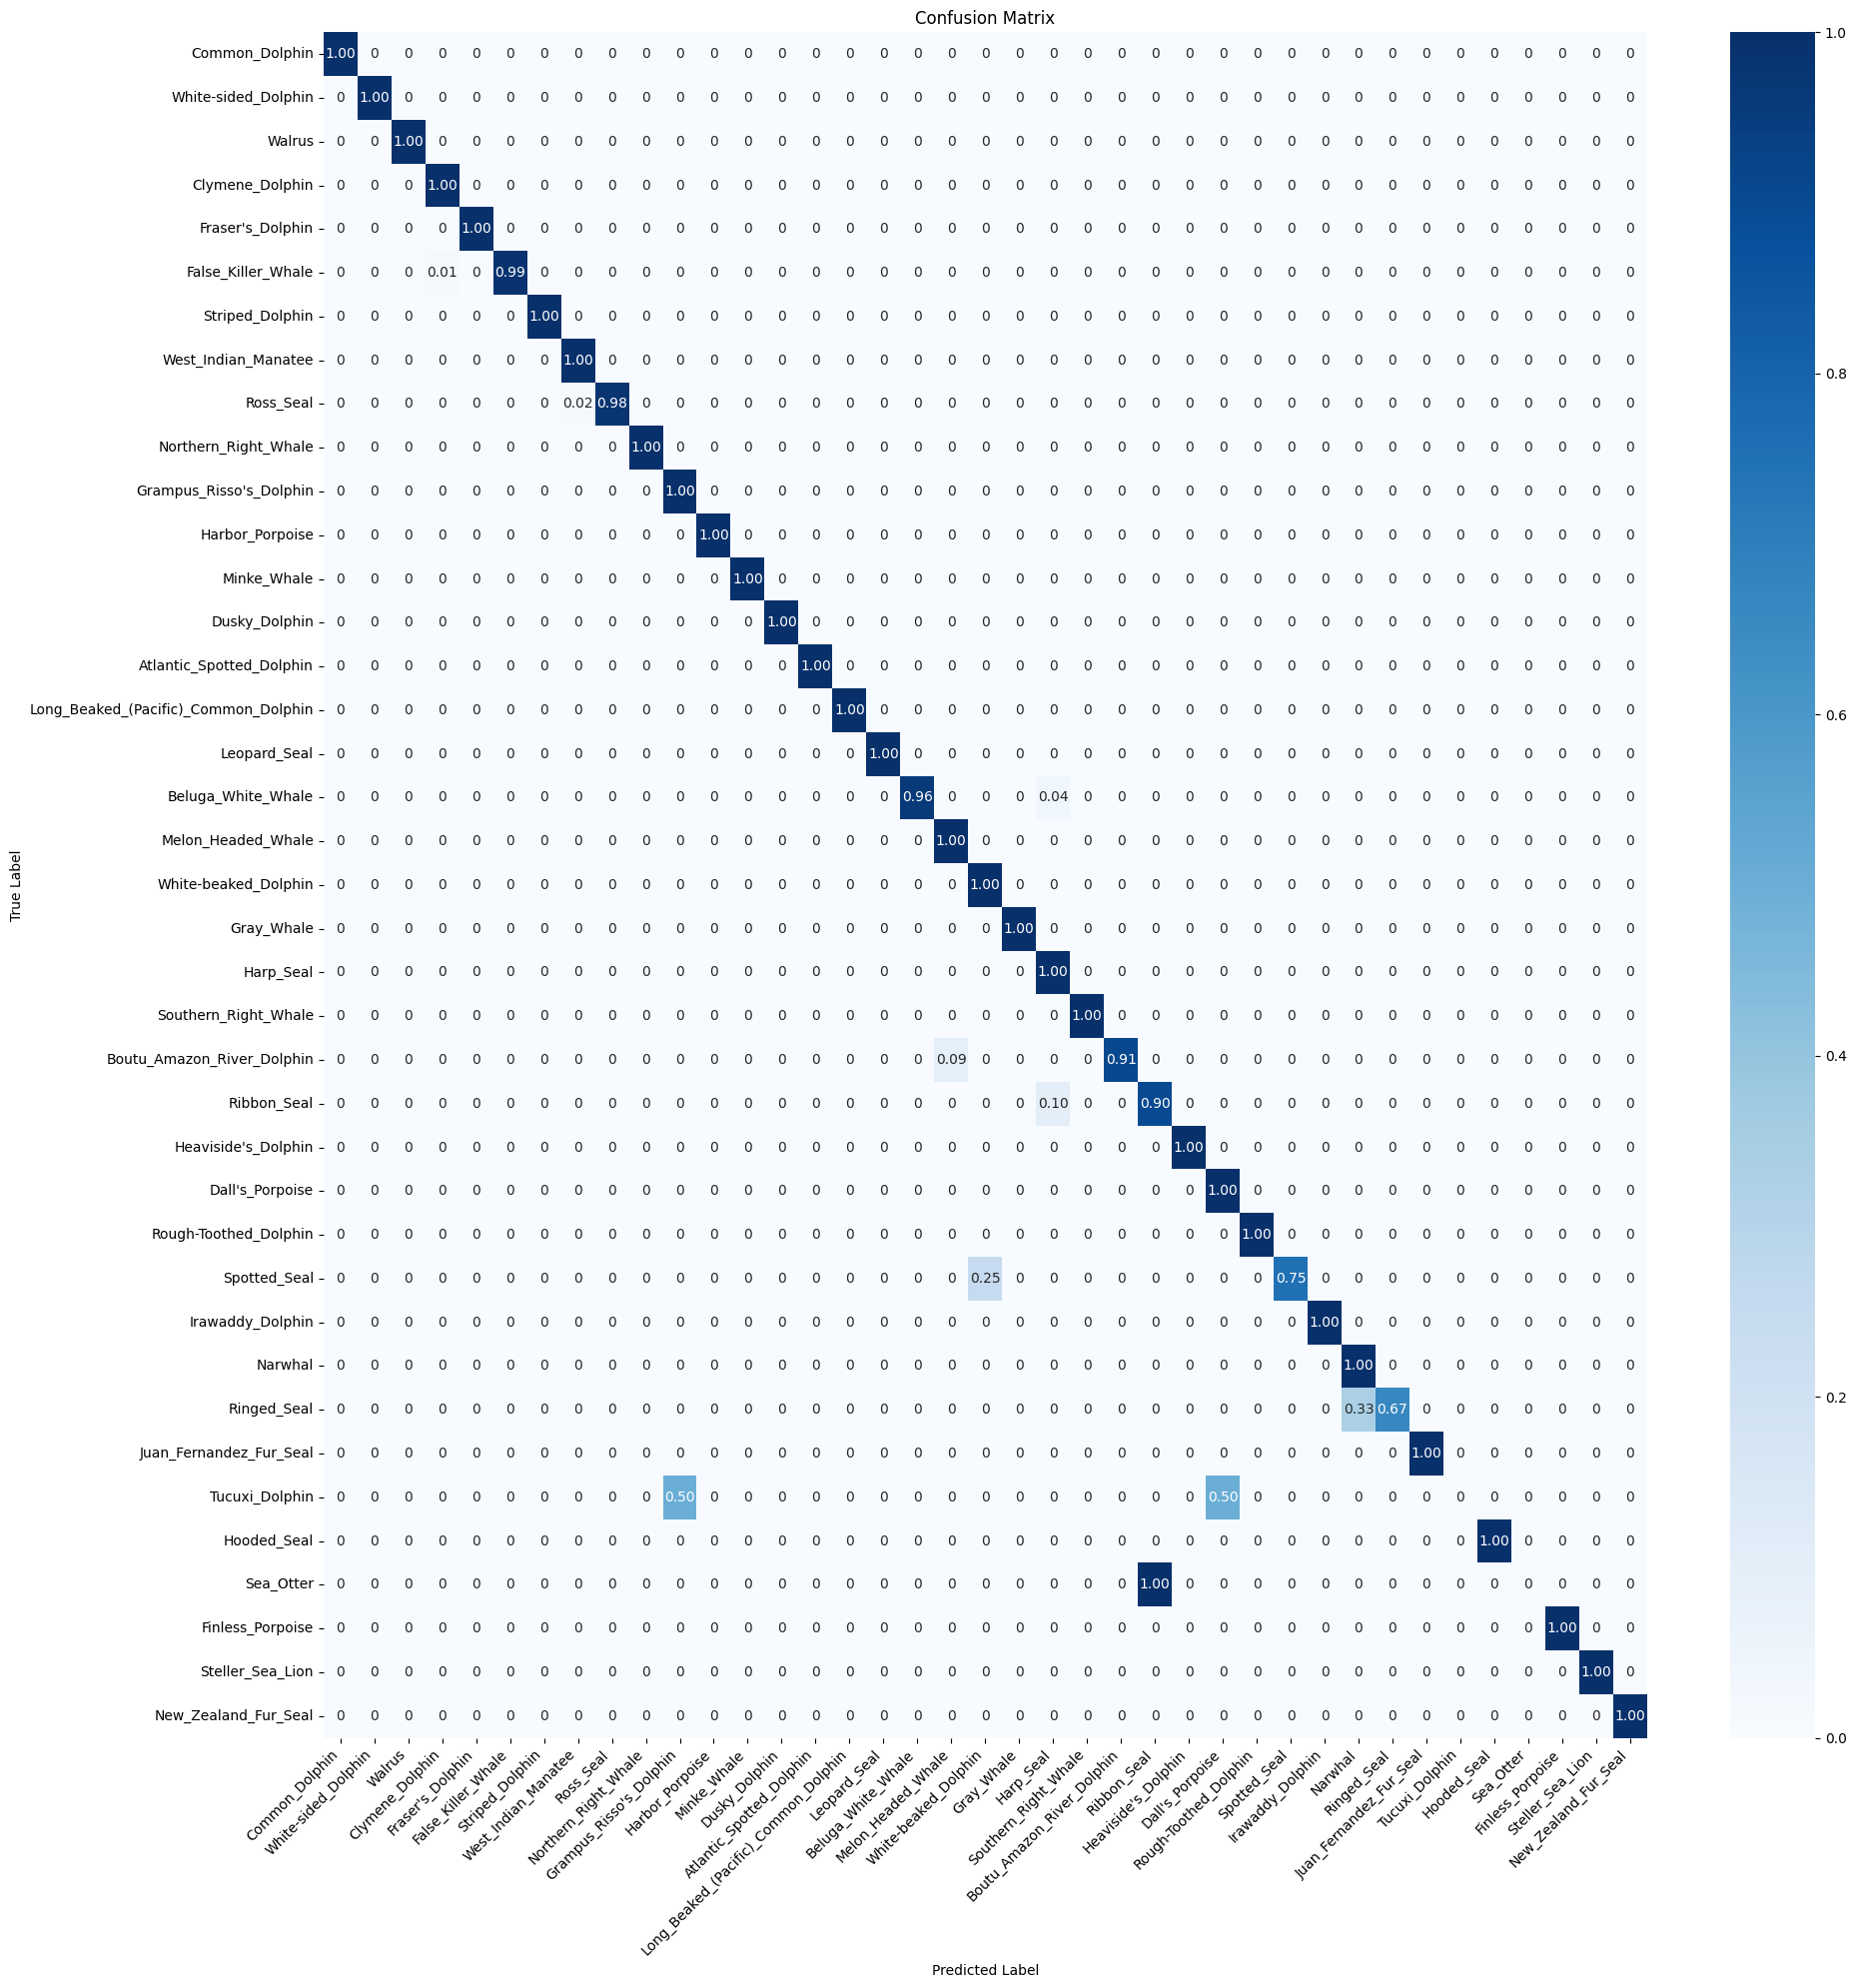

In [6]:
label_list = list(y_mapping.keys())
cm = tf.math.confusion_matrix(y_test, y_pred,).numpy()
accuracy_dict = confusion_matrix_plot(cm, label_list)